In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import warnings
warnings.filterwarnings('ignore')

import pickle
import numpy as np

from utils import plot_metric

In [4]:
with open("optimize_data/all_methods.pkl", "rb") as file:
    log = pickle.load(file)
    
with open("optimize_data/buffer_size.pkl", "rb") as file:
    log_buffer = pickle.load(file)

In [8]:
DATA = ["a1a", "breast-cancer_scale", "sythetic"][0] # можно прогнать для любой

Помимо L-BFGS я также реализовал простой BFGS, чтобы можно было сравнить и с ним тоже.

# L-BFGS History Size

Прежде всего посмотрим на то, как ведет себя метод при разном размере очереди, в которой мы храним историю для пересчета гессиана и направления в оптимизации. По времени на а1а ожидаемо лучше всего сходятся с большим размером очереди (за исключением 50, но итоговая точность все равно лучше, чем у тех, что используют меньше). 

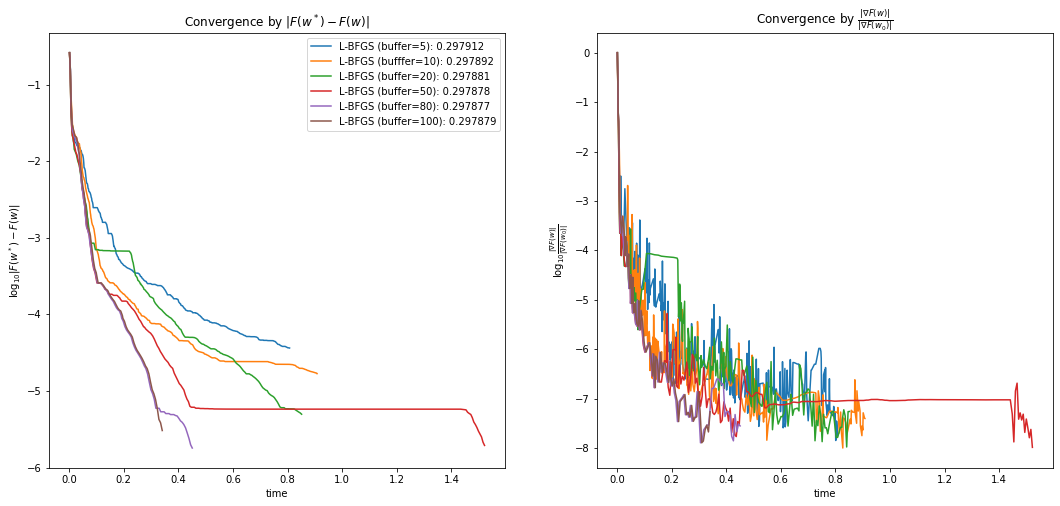

In [10]:
plot_metric(log_buffer, DATA, "time")

Однако кажется странным использовать размер очереди больше, чем количество итераций до сходимости. Получается, что мы используем все информацию, что равносильно обычному BFGS (хотя гессиан мы все еще не храним явно). Лучшим выбором мне кажется использовать размер 80.

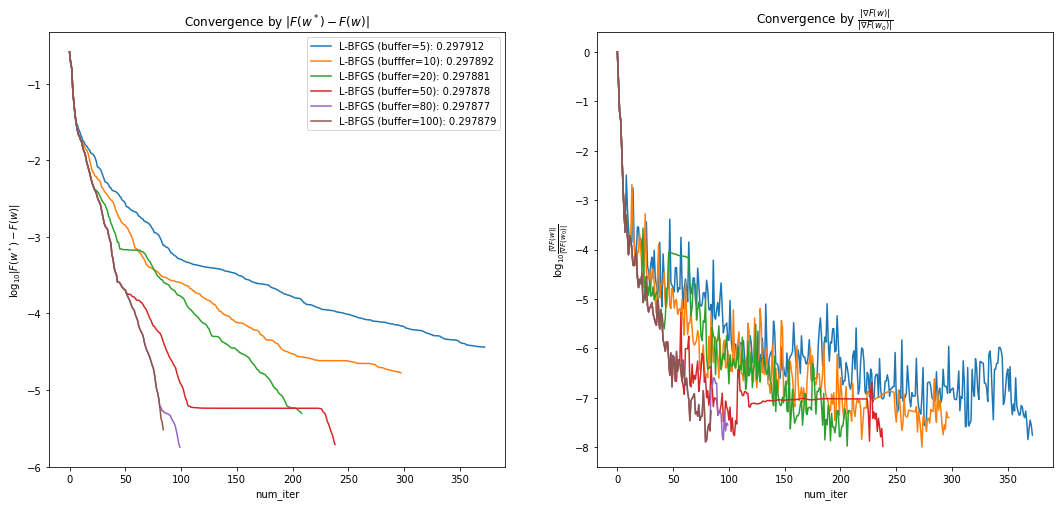

In [31]:
plot_metric(log_buffer, DATA, "num_iter")

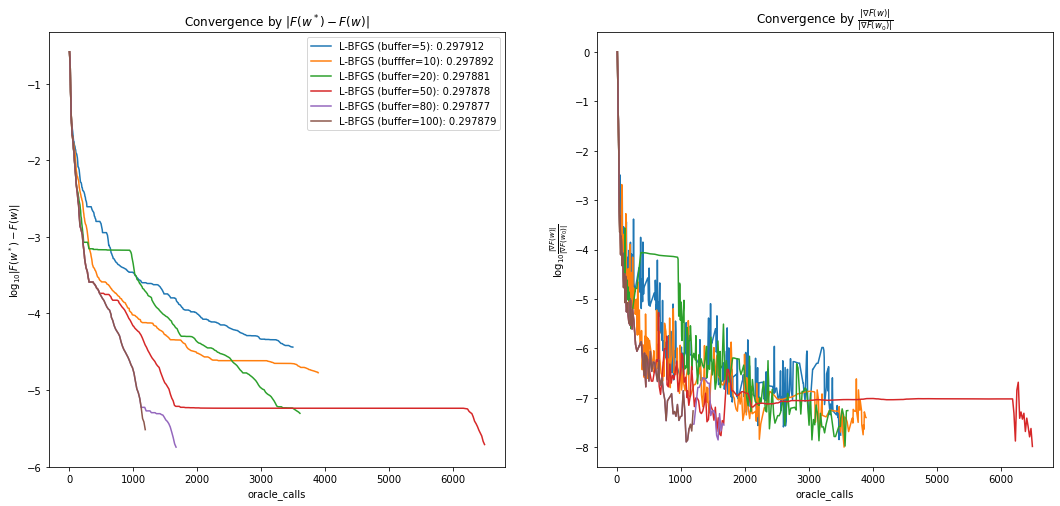

In [32]:
plot_metric(log_buffer, DATA, "oracle_calls")

# All Methods

<table>
    <tr>
    <th style="text-align:center"> A1A </th>
    <th style="text-align:center"> Breast Cancer </th>
    <th style="text-align:center"> Synthetic </th>
    </tr>
<tr><td>

| method                       |   entropy |   num iter |   oracle calls |   mean mem usage, MiB |   time, s |
|------------------------------|-----------|------------|----------------|-----------------------|-----------|
| Gradient Descent (armijo)    |  0.298265 |       3897 |          31377 |               105.567 |      6.63 |
| Newton (wolfe)               |  0.297876 |         10 |            157 |               108.394 |      0.07 |
| Hessian-Free Newton (armijo) |  0.297878 |         11 |            679 |               108.398 |      0.21 |
| BFGS (wolfe)                 |  0.297878 |        178 |           2207 |               109.289 |      0.55 |
| L-BFGS (wolfe)               |  0.297879 |         85 |           1189 |               109.471 |      0.31 |

</td><td>
    
| method                       |   entropy |   num iter |   oracle calls |   mean mem usage, MiB |   time, s |
|------------------------------|-----------|------------|----------------|-----------------------|-----------|
| Gradient Descent (armijo)    | 0.0754031 |        904 |           8136 |               109.508 |      1.02 |
| Newton (wolfe)               | 0.0753187 |          8 |             33 |               109.508 |      0.02 |
| Hessian-Free Newton (armijo) | 0.0753188 |          7 |            108 |               109.508 |      0.02 |
| BFGS (wolfe)                 | 0.0753191 |         42 |            279 |               109.512 |      0.04 |
| L-BFGS (wolfe)               | 0.0753189 |         27 |            187 |               109.512 |      0.03 |
    
</td><td>
    
| method                       |      entropy |   num iter |   oracle calls |   mean mem usage, MiB |   time, s |
|------------------------------|--------------|------------|----------------|-----------------------|-----------|
| Gradient Descent (armijo)    |  0.000368444 |        785 |           7333 |               110.348 |      0.77 |
| Newton (wolfe)               | -1.0001e-12  |          9 |             83 |               110.061 |      0.02 |
| Hessian-Free Newton (armijo) | -1.0001e-12  |          8 |           1148 |               110.035 |      0.14 |
| BFGS (wolfe)                 |  3.36889e-06 |         42 |            393 |               110.046 |      0.06 |
| L-BFGS (wolfe)               |  8.57569e-06 |         15 |            118 |               110.035 |      0.02 |
    
</td></tr> 

</table>

Кажется не имеет особого смысла сравнивать методы с градиентным спуском (во всяком случае на одном графике) ибо очевидно, что они все сходятся быстрее, можно посмотреть в табличке. В сравнении по времени работы оба метода BFGS оказываются сильно дольше (почти в два раза или больше), чем реализованные ранее Ньютон и неточный Ньютон. Но достигаю точности большей, чем неточный метод Ньютона.

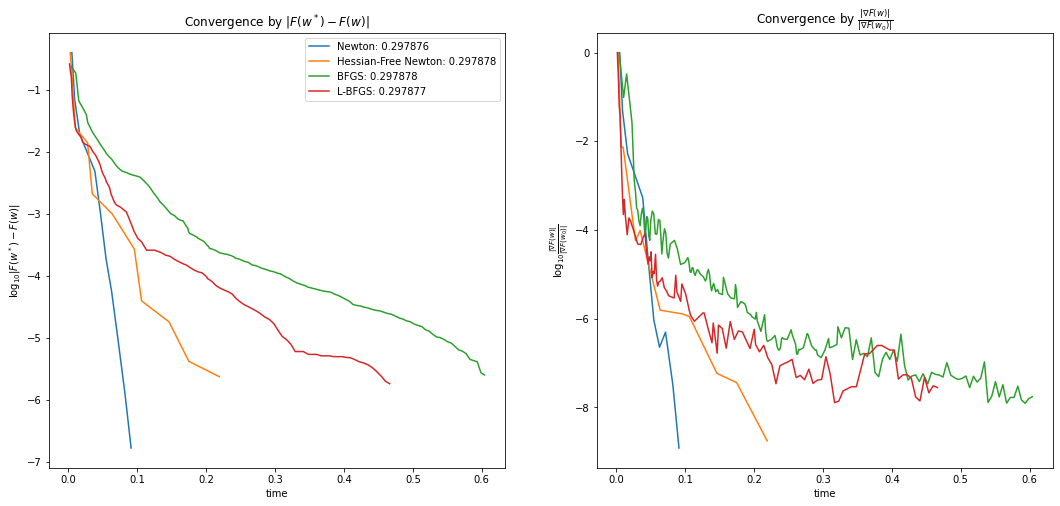

In [33]:
plot_metric(log, DATA, "time")

По количесту итераций, правда, они оказываются хуже (что не очень важно, т.к. мы смотрим на время). Интересно, что L-BFGS сходится быстрее, чем обычный BFGS.

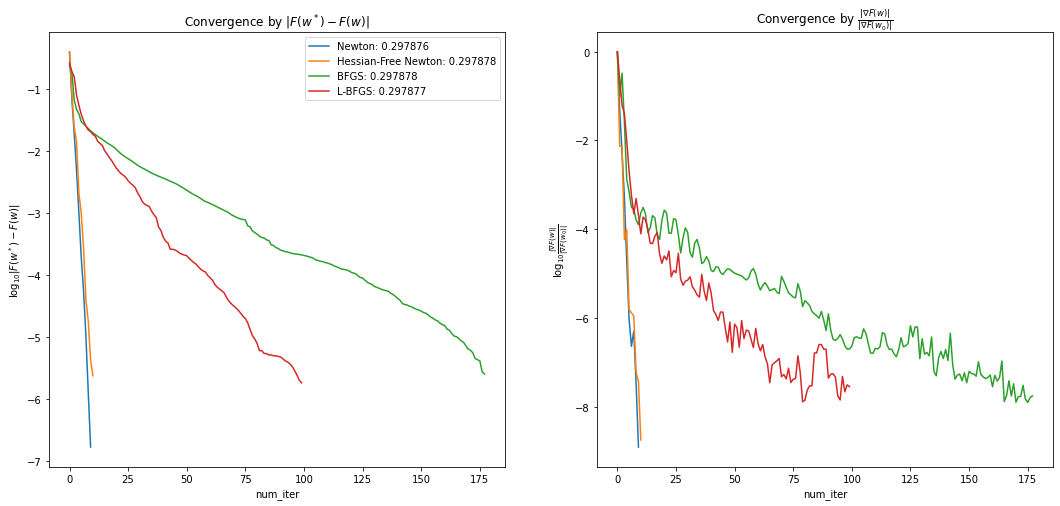

In [9]:
plot_metric(log, DATA, "num_iter")

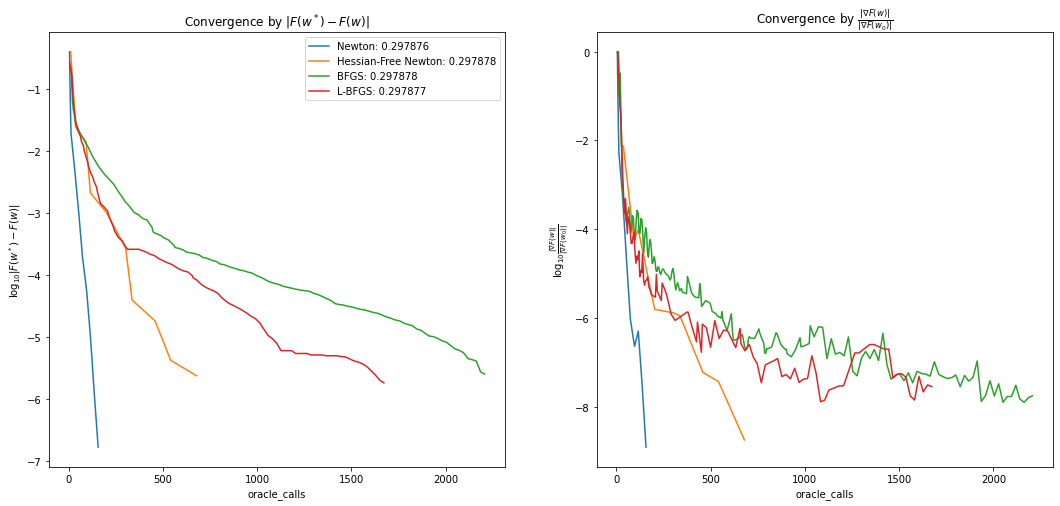

In [35]:
plot_metric(log, DATA, "oracle_calls")

# Conclusion

Интересно, что L-BFGS сходится быстрее, чем BFGS, при том, что размер истории больше, чем количество итераций до сходимости. В таком случае (как об этом говорится в учебнике) он должен быть аналогичен BFGS, но сходится быстрее. Оба метода сильно зависят от начальной $\gamma$, на которую мы домножаем начальную аппроксимацию. Заметил, что при правильном подборе оба методы могут сходится из довольно странных начальных весов (больших или по разному распределенных), в отличие от методов Ньютона. В целом оба методы оказываются не сильно лучше чем метод Ньютона, но гораздо стабильнее.